In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cmocean
import matplotlib
plt.rcParams["figure.figsize"] = 10, 8
%matplotlib inline

# ----------------------------------------------------------------------------------------------
### Importar dados do MODIS

In [2]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [3]:

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [7]:
nc_path = os.path.join(data_folder, "AQUA_MODIS.20220209T133501.L2.SST.NRT.nc")

In [8]:
nc_path

'/home/luisfigueiredo/JUNO/notebooks/../data/AQUA_MODIS.20220209T133501.L2.SST.NRT.nc'

In [10]:

ds = xr.open_dataset(nc_path, group='geophysical_data')
df = ds.to_dataframe()

In [11]:
df

sst  qual_sst  flags_sst  bias_sst  stdv_sst  \
number_of_lines pixels_per_line                                                 
0               0                NaN       4.0        1.0     -18.0     -18.0   
                1                NaN       4.0        1.0     -18.0     -18.0   
                2                NaN       4.0        1.0     -18.0     -18.0   
                3                NaN       4.0        1.0     -18.0     -18.0   
                4                NaN       4.0        1.0     -18.0     -18.0   
...                              ...       ...        ...       ...       ...   
2029            1349             NaN       4.0        1.0     -18.0     -18.0   
                1350             NaN       4.0        1.0     -18.0     -18.0   
                1351             NaN       4.0        1.0     -18.0     -18.0   
                1352             NaN       4.0        1.0     -18.0     -18.0   
                1353             NaN       4.0        1.0     -18.0     -18.0   

                                 sstref  l2_flags  
number_of_lines pixels_per_line                    
0               0                   NaN        50  
                1                   NaN        50  
                2                   NaN        50  
                3                   NaN        50  
                4                   NaN        50  
...                                 ...       ...  
2029            1349               -3.0  33619984  
                1350               -3.0  33619984  
                1351               -3.0  33619984  
                1352               -3.0  33619984  
                1353               -3.0  33619984  

[2748620 rows x 7 columns]

# ----------------------------------------------------------------------------------------

### Código: Load das variaveis MATLAB

In [ ]:

## LOAD das variáveis necessários do netCDF (Este exemplo é com imagens
# MODIS - os caminhos podem ser diferentes)
lon=ncread('AQUA_MODIS.20220209T133501.L2.SST.NRT.nc', '/navigation_data/longitude');
lat=ncread('AQUA_MODIS.20220209T133501.L2.SST.NRT.nc', '/navigation_data/latitude');
sst=ncread('AQUA_MODIS.20220209T133501.L2.SST.NRT.nc', '/geophysical_data/sst');
qual_sst=ncread('AQUA_MODIS.20220209T133501.L2.SST.NRT.nc', '/geophysical_data/qual_sst');

# factor de qualidade para as imagens MODIS - esta linha é para comentar no
# caso do MUR e/ou modelo
sst(qual_sst>1)=NaN;

# Figura com os dados SST - grelha irregular L2
pcolor(lon,lat,sst); shading flat; colorbar

# interpolar dados para uma grelha antes - também não é necessário nos dados L3, L4 ou Modelo

Z1=double(sst);
X1=double(lon);
Y1=double(lat);
X1(isnan(X1))=0;  #caso lon tenha NaN values, estes são convertidos para zeros
Y1(isnan(Y1))=0;  #caso lat tenha NaN values, estes são convertidos para zeros

[X,Y]=meshgrid(-27.296:.02:7.4435,32.2344:0.02:53.7133);    #Lon_min, lon_max; lat_min, lat_max dados MODIS

Z=griddata(X1,Y1,Z1,X,Y);

# Z = griddata(X1,Y1,Z1,X,Y) fits a surface of the form Z1 = f(X1,Y1) to the scattered data in the vectors (X1,Y1,Z1).
# The griddata function interpolates the surface at the query points specified by (X,Y) and returns the interpolated values, Z

#### Código: LOAD das variaveis em Python (passo a passo)

In [11]:
lon = np.array([1,2,3,4,5,6])
lat = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
sst = np.arange(1,91, dtype=np.double).reshape(6,15) 
#lon, lat e sst são dummy variables aqui

lon[np.isnan(lon)] = 0    #caso lon tenha NaN values, estes são convertidos para zeros
lat[np.isnan(lat)] = 0    #caso lat tenha NaN values, estes são convertidos para zeros


# corresponde ao [X,Y]=meshgrid(-27.296:.02:7.4435,32.2344:0.02:53.7133); do MATLAB
# No entanto como estamos a usar valores dummy isto para já não serve para nada
#X = np.arange(-27.296, 7.4435, 0.02)
#Y = np.arange(32.2344, 53.7133, 0.02) 
#X, Y = np.meshgrid(X, Y)

X1 = np.linspace(-27.296, 7.4435, 6)
Y1 = np.linspace(32.2344, 53.7133, 15)
X1, Y1 = np.meshgrid(X1, Y1)

lon, lat = np.meshgrid(lon, lat)

from scipy.interpolate import griddata
Z = griddata((lon.flatten(), lat.flatten()), sst.flatten(), (X1, Y1), method='linear')

### Código: Definição da janela MATLAB

In [13]:
#####################################

# Definição da janela

head(1:2) = [-27.296 7.4435];             #cria variavel head com esses 2 valores nas posiçoes 1 e 2
head(3:4) = [32.2344 53.7133];
z_dim=size(Z); #dimensões da matriz Z
z_actual_range = double([min(Z(:)) max(Z(:))]); #range dos dados
	nx = z_dim(end);		ny = z_dim(end-1);
    node_offset = 0;	
 
	head(5:7) = double([z_actual_range node_offset]);
	head(8) = diff(head(1:2)) / (nx - ~node_offset);
	head(9) = diff(head(3:4)) / (ny - ~node_offset);
    
############################################ 

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 10)

#### Código: Definição da janela em Python (passo a passo)

In [14]:
head = np.array([-27.296, 7.4435])           #Extremos do array que se obtem com a meshgrid em X
head = np.append(head, [32.2344, 53.7133])   #Extremos do array que se obtem com a meshgrid em Y
#create dummy array Z to test 
#Z = np.array([[1,2,3,4,5,6],[1,1,1,1,1,1],[1,2,3,4,5,6],[1,1,1,1,1,1],[1,2,3,4,5,6],
 #            [1,1,1,1,1,1],[1,2,3,4,5,6],[1,1,1,1,1,10],[1,2,3,4,5,6],[1,1,1,1,1,1],
  #           [1,2,3,4,5,6],[1,1,1,1,1,1],[1,2,3,4,5,6],[1,1,1,1,1,1],[1,2,3,4,5,6],
   #           [1,1,1,1,1,1],[1,2,3,4,5,6],[1,1,1,1,1,1],[1,2,3,4,5,6],[1,1,1,1,1,1]])

z_dim = Z.shape    #dimensões da matriz Z (rows, cols)

z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])    #range dos dados (valor minimo e maximo da matriz Z)
nx = z_dim[1]      # number of columns of matrix Z
ny = z_dim[0]      # number of rows of matrix Z
node_offset = 0

    
#index 4 -> menor valor de Z; index5 -> maior valor de Z; index6 -> node_offset=6
head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     #index 7 -> quociente da diferença dos extremos da meshgrid em X e o nr de colunas-1
head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     #index 8 -> quociente da diferença dos extremos da meshgrid em Y e o nr de rows-1

/tmp/ipykernel_128114/3156741053.py:11: RuntimeWarning: All-NaN slice encountered
  z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])    #range dos dados (valor minimo e maximo da matriz Z)


In [16]:
head

array([-27.296     ,   7.4435    ,  32.2344    ,  53.7133    ,
                nan,          nan,   0.        ,   6.9479    ,
         1.53420714])

### Código: Definição da parametros MATLAB

In [ ]:
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%  

% Window size 32 × 32

% Window clarity (% of data have to present in the window) 75%
% Overlap 50%

% The ratio of variance between the two populations to the
% variance within the populations θ(τopt )% 0.76

% Gradient ratio 0.9

% Cohesion coefficients [C1, C2, C] [0.9, 0.9, 0.92]
% Mean temperature difference between the two populations (surface waters)
% .25

   %cayula
    minPopProp = 0.20;				% 
	minPopMeanDiff = 0.4;
	minTheta = 0.70;
	minSinglePopCohesion = 0.90;
	minGlobalPopCohesion = 0.70;
   %nieto
%     minPopProp = 0.15;				% 
% 	minPopMeanDiff = 0.4;
% 	minTheta = 0.70;
% 	minSinglePopCohesion = 0.90;
% 	minGlobalPopCohesion = 0.70;
%%%%%%%%%%%%%%%%%%%%%%%

#### Código: Definição da parametros Python (passo a passo)

In [161]:
################################# 

# Window size 32 × 32

# Window clarity (% of data have to present in the window) 75%
# Overlap 50%

# The ratio of variance between the two populations to the
# variance within the populations θ(τopt )% 0.76

# Gradient ratio 0.9

# Cohesion coefficients [C1, C2, C] [0.9, 0.9, 0.92]
# Mean temperature difference between the two populations (surface waters)
# .25

#cayula
minPopProp = 0.20
minPopMeanDiff = 0.4
minTheta = 0.70
minSinglePopCohesion = 0.90
minGlobalPopCohesion = 0.70

#nieto
# minPopProp = 0.15
# minPopMeanDiff = 0.4
# minTheta = 0.70
# minSinglePopCohesion = 0.90
# minGlobalPopCohesion = 0.70

##################################

### Código: 1ª For Loop MATLAB

In [ ]:
%%%%%%%%%%%%%%%%%%%%%%%

[n_rows, n_cols] = size(Z);
	winW16 = 16;	winW32 = 2*16;		winW48 = 3*16;
	s = 0;				% s = 1 means subwindows do NOT share a common border. With s = 0 they do.
	xSide16 = winW16 * head(8);
	ySide16 = winW16 * head(9);
	xSide32 = (winW32 - s) * head(8);			% X and Y sizes of the 32x32 window in real coordinates
	ySide32 = (winW32 - s) * head(9);			% -1 because coords are in grid registration
	nWinRows = floor(n_rows / winW16);		nWinCols = floor(n_cols / winW16);
	for (wRow = 1:nWinRows-2)
		r1 = (wRow - 1) * winW16 + 1;		r2 = r1 + winW48 - s;	% Start and stop indices and coords of current window
		y0 = head(3) + (wRow-1) * ySide16;				%y1 = y0 + (winW48-1) * head(9);
		for (wCol = 1:nWinCols-2)
			c1 = (wCol - 1) * winW16 + 1;	c2 = c1 + winW48 - s;
			x0 = head(1) + (wCol-1) * xSide16;			%x1 = x0 + (winW48-1) * head(8);
			wPad = Z(r1:r2, c1:c2);						% 48x49 (or 48x48 if s == 1) Window
			% |4|3|
			% |1|2|
			% Rows and columns of the 4 sub-windows (avoids a double loop). We loop along the order of the
			% above sketch. There will be a common region when we slide the 33x33 window with shifts of 16
			% When we at 1 (a 33x33 window) that common zone is depicted at position 1 form the sketch below,
			% and so forth for the other three positions.
			rr = [1 1 2 2];		cc = [1 2 2 1];

			% Set the index of the four corner windows of 17x17 representing each the same physical region
			% when we loop 4 times the sliding window of 33x33 in the larger 49x49 window (above sketch).
			% |2|1|
			% |3|4|
			if (s == 1),	corners = [17 32 17 32; 17 32 1 16; 1 16 1 16; 1 16 17 32];		% Less good
			else			corners = [17 33 17 33; 17 33 1 17; 1 17 1 17; 1 17 17 33];
			end

			for (k = 1:4)					% Loop over the 4 sliding 32x32 sub-windows of the larger 48x48 one.
				m1 = (rr(k) - 1) * winW16 + 1;			m2 = m1 + 2*winW16 - s;		% indices of the sliding 33x33 window
				n1 = (cc(k) - 1) * winW16 + 1;			n2 = n1 + 2*winW16 - s;
				w = double((wPad(m1:m2, n1:n2)));					% Sub-window with size 33x33
				subWinX0 = x0 + (cc(k)-1) * xSide16;	subWinX1 = subWinX0 + xSide32;	% Corner coordinates
				subWinY0 = y0 + (rr(k)-1) * ySide16;	subWinY1 = subWinY0 + ySide32;
				R = [subWinX0 subWinX1 subWinY0 subWinY1];
				[x, y, z, exitType] = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, ...
													   minSinglePopCohesion, minGlobalPopCohesion, corners(k,:));
				if (~exitType)       #terminates MATLAB program (same as quit)
					h=line('XData',x, 'YData',y, 'userdata',z, 'Tag','SSTfront');
                    # Tag -> nas propriedades da imagem, a figure vai ter o Tag 'SSTfront'
					%rectX = [subWinX0 subWinX0 subWinX1 subWinX1 subWinX0];
					%rectY = [subWinY0 subWinY1 subWinY1 subWinY0 subWinY0];
					%hl = line('XData',rectX, 'YData',rectY, 'Parent',hMirHand.axes1);
					%hl = line('XData',[x0 x0 x1 x1 x0], 'YData',[y0 y1 y1 y0 y0], 'Parent',hMirHand.axes1);
					%draw_funs(hl,'line_uicontext')		% Set lines's uicontextmenu
				end
			end

		end
		drawnow
    end
% ---------------------------------------------------------------------------------------------------


#### Código: 1ª For Loop Python (passo a passo)

In [213]:
[n_rows, n_cols] = Z.shape
winW16 = 16
winW32 = 16*2
winW48 = 16*3

s=0 #s=1 means subwindows do NOT share a common border. With s = 0 they do.

xSide16 = winW16*head[7]
ySide16 = winW16*head[8]
xSide32 = (winW32 - s) * head[7]
ySide32 = (winW32 - s) * head[8]

nWinRows = math.floor(n_rows/winW16)
nWinCols = math.floor(n_cols/winW16)


for wRow in range(1, nWinRows-1):    #estava -3 antes
    r1 = (wRow-1) * winW16 + 1;
    r2 = r1 + winW48 -s     #start and stop indices and coords of current window
    y0 = head[2] + (wRow-1)*ySide    #y1 = y0 + (winW48-1)*head[8]
    
    for wCol in range(1, nWinCols-1):     #estava -3 antes
        c1 = (wCol - 1)*winW16+1
        c2 = c1 + winW48 - s
        x0 = head[0] + (wCol-1) * xSide16     #x1 = x0 + (winW48-1)*head[7]
        wPad = Z[r1-1:r2, c1-1:c2]
        
        rr = np.array([1,1,2,2])
        cc = np.array([1,2,2,1])
        
        if s==1:
            corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
        else:
            corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
        for k in range(0,4):     #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
            m1 = (rr[k] - 1) * winW16 + 1
            m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
            ni = (cc[k] - 1) * winW16 + 1
            n2 = n1 + 2 * winW16 - s
            
            w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
            subWinX0 = X0 + (cc[k] - 1) * xSide16
            subWinX1 = subWinX0 + xSide32
            
            subWinY0 = y0 + (rr[k] - 1) * ySide16
            subWinY1 = subWinY0 + ySide32
            
            R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
            
            [x, y, z, exitType] = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
            if (not exitType):
               #  h = line('XData', x, 'YData', y, 'userdata', z, 'Tag', 'SSTfront')  
                #Tag -> nas propriedades da imagem, a figure vai ter o Tag 'SSTfront' (em MATLAB)
                h = plt.plot(x,y,z)       #DUVIDA
                
                
    #DUVIDA se uso o drawnow?
    plt.show()
        
        

#### Duvida:

    Em MATLAB é usada a função line('XData', x, 'YData', y, 'userdata', z, 'Tag', 'SSTfront'). Função line()   adds the line to the current axes without deleting other graphics objects or resetting axes properties,    sendo que plt.plot() não faz isso.
    
    In MATLAB drawnow is used. Drawnow updates figures and processes any pending callbacks. This command is used if we want to modify graphic objects and want to see the updates on the screen immediately. I don't know if the drawnow is really necessary. In python we can also use drawnow but does require small changes to the code, like moving figure(); plot(...); show() inside a function;

In [40]:
w_PAD = Z[4:10, 2:5].astype('double')

In [41]:
w_PAD

array([[3., 4., 5.],
       [1., 1., 1.],
       [3., 4., 5.],
       [1., 1., 1.],
       [3., 4., 5.],
       [1., 1., 1.]])

### Código: function getFrontInWindow() MATLAB

In [ ]:
%% função especifica. Pode ficar noutro ficheiro e ser chamada
function [xdata, ydata, z, exitType] = getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, ...
                                       minSinglePopCohesion, minGlobalPopCohesion, corners)
% ...
% If CORNERS exist than it holds the start and stop index of 1/4 sub-window of W inside which
% we will retain the fronts found. Detections outside this sub-window are ignored
%
% Here we follow, patially, what is donne in MGET (FrontUtils.cpp by Jason Roberts) that in turn,
% according to program's notes, followed an original Fortran code by Dave Ulman.

	if (nargin < 8),	corners = [];	end
	xdata = [];		ydata = [];		z = [];		exitType = 0;

	mask = isnan(w);	
	haveNaNs = any(mask(:));
	n_NaNs = 0;
	if (haveNaNs)
		n_NaNs = sum(mask(:));
		if (n_NaNs / numel(w) > 0.5)			% Window must be at least > half filled
			exitType = -1;
			return
		end
	end

	mi_ma = double([min(w(:)) max(w(:))]);		
	n = ceil(diff(mi_ma) / 0.02);
% 	[y,xout] = histo_m('hist',w(:), n, mi_ma); o hist funciona
    [y,xout] = hist(w(:),n,mi_ma);  % esta é a função histograma do MATLAB. deve haver algo parecido no python

	thresValue = xout(1);	totalCount = numel(w) - n_NaNs;
	threshPopACount = 0;	threshSeparation = -1;
	threshPopAMean = 0;		threshPopBMean = 0;

	w(mask) = 0;				% Replace NaNs with 0's
	totalSum = sum(w(:));
	totalSumSquares = sum(w(:) .* w(:));

	for (k = 2:n-1)				% Ignore first and last as candidates
		popASum = sum(y(1:k) .* xout(1:k));
		popBSum = sum(y(k+1:end) .* xout(k+1:end));
		popACount = sum(y(1:k));
		popBCount = sum(y(k+1:end));

		popAMean = popASum / popACount;
		popBMean = popBSum / popBCount;
		separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean);
		if (separation > threshSeparation)
			threshSeparation = separation;
			thresValue = xout(k);
			threshPopACount = popACount;
			threshPopAMean = popAMean;
			threshPopBMean = popBMean;
		end
	end

	% Continue only if the proportional size of the smaller population exceeds the minimum allowed value.
	% This test corresponds to equation 14 in Cayula-Cornillon
	if (threshPopACount / totalCount < minPopProp)
		exitType = 1;
		return
	end
	if (1.0 - threshPopACount / totalCount < minPopProp)
		exitType = 1;
		return
	end
	% Abort this window if the difference in the populations' means is less than a minimum value.
	if (threshPopBMean - threshPopAMean < minPopMeanDiff)
		exitType = 2;
		return
	end

	% Calculate the criterion function THETA(TAUopt) discussed on page 72 of the paper.
	totalMean = totalSum / totalCount;
	variance = totalSumSquares - (totalMean * totalMean * totalCount);
	theta = threshSeparation / (variance * totalCount);
	if (theta < minTheta)
		exitType = 3;
		return
	end

	% Cohesion
	% Count the number of times a population A cell is immediately adjacent to another population A cell,
	% and the same for population B. A cell can be adjacent on four sides. Count only two of them
	% (bottom and right side) because doing all four would be redundant. Do not count diagonal neighbors.
	countANextToA = 0;		countBNextToB = 0;
	countANextToAOrB = 0;	countBNextToAOrB = 0;
	[n_rows, n_cols] = size(w);
	for (col = 1:n_cols-1)
		for (row = 1:n_rows-1)
			if (haveNaNs && (mask(row,col) || mask(row+1,col) || mask(row, col + 1)))
				continue
			end
			% Examine the bottom neighbor
			if (w(row,col) <= thresValue)
				countANextToAOrB = countANextToAOrB + 1;
				if (w(row + 1, col) <= thresValue)
					countANextToA = countANextToA + 1;
				end
			else
				countBNextToAOrB = countBNextToAOrB + 1;
				if (w(row + 1, col) > thresValue)
					countBNextToB = countBNextToB + 1;
				end
			end
			% Examine the right neighbor
			if (w(row,col) <= thresValue)
				countANextToAOrB = countANextToAOrB + 1;
				if (w(row, col + 1) <= thresValue)
					countANextToA = countANextToA + 1;
				end
			else
				countBNextToAOrB = countBNextToAOrB + 1;
				if (w(row, col + 1) > thresValue)
					countBNextToB = countBNextToB + 1;
				end
			end

		end
	end
	
	popACohesion = countANextToA / countANextToAOrB;
	popBCohesion = countBNextToB / countBNextToAOrB;
	globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB);
	if (popACohesion < minSinglePopCohesion)
		exitType = 4;
		return
	end
	if (popBCohesion < minSinglePopCohesion)
		exitType = 4;
		return
	end
	if (globalCohesion < minGlobalPopCohesion)
		exitType = 4;
		return
	end

	% OK, if we reach here we have a front. Compute its contour. This part is not discussed in any
	% of the papers I saw and is different from the aproach followed in MGET.
	X = linspace(head(1),head(2), n_cols);
	Y = linspace(head(3),head(4), n_rows);
	if (isempty(corners))		% Use the full window
		w = double(w);			% It has to be because of the contourc
		if (haveNaNs)
			w(w == 0) = NaN;	% Need to restore the NaNs to not invent new contours around zeros
		end
		c = contourc(X,Y,w,[thresValue thresValue]);
	else
		% The four corners have these indices [17 32 17 32; 17 32 1 16; 1 16 1 16; 1 16 17 32]
		% and the variable corners has one of its rows (the current to be retained sub-window)
		X = X(corners(3):corners(4));
		Y = Y(corners(1):corners(2));
		w = double(w(corners(1):corners(2), corners(3):corners(4)));
		if (haveNaNs)
			w(w == 0) = NaN;
		end
		if (~all(all(isnan(w))))    % Sometimes w is all NaNs, which would screw later.
			c = contourc(X,Y,w,[thresValue thresValue]);
		else
			c = [];
		end
	end
	limit = size(c,2);
	i = 1;
	while(i < limit)
		npoints = c(2,i);
		x = c(1,i+1:i+npoints);		y = c(2,i+1:i+npoints);
		if (x(1) == x(end) || npoints < 7)		% We don't want closed lines nor very short ones
			i = i+npoints+1;
			continue
		end
		if (isempty(xdata))			% First contour
			xdata = x;	ydata = y;
		else
			xdata = [xdata NaN x];
			ydata = [ydata NaN y];
		end
		i = i+npoints+1;
		%xdata = c(1,2:npoints+1);		ydata = c(2,2:npoints+1);
	end
	z = thresValue;
	
	if (isempty(xdata))
		exitType = 5;
    end 
end

### Código: function getFrontInWindow() in Python (passo a passo)

In [206]:
def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    #empty arrays de xdata, ydata e z
    xdata = np.array([])
    ydata = np.array([])
    z = np.array([])
    exitType=0
    
    #mask é um array com a shape de w, que vai ser 1 se nessa posição w for np.nan e 0 caso contrário
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 se mask tiver 1s (que correspondem a NaNs na matriz w)
    n_NaNs=0
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])       #contar nr de 1s (NaNs na matriz w) que existem
        if (n_NaNs/len(w.flatten())>0.5):     #window não pode ter mais de 50% dos seus pixeis como NaNs
            exitType=-1
            return
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]        #array com valor minimo e máximo de w
    n = math.ceil((mi_ma[1]-mi_ma[0])/0.02)     #numero de bins
    bins = np.arange(0.01, mi_ma[1], 0.02)      #definir a sequencia dos Bins e ter resultados iguais ao MATLAB
    [y, xout] = np.histogram(w[:], bins, mi_ma)    #y->frequency counts, Xout->bin location   
    #DUVIDA -> valored de Y estão a dar diferentes dos do MATLAB
    
    thresValue = xout[0]        
    totalCount = len(w.flatten()) - n_NaNs    #nr de pixeis não NaNs que existem
    threshPopACount = 0
    threshSeparation = -1
    threshPopAMean = 0
    threshPopBMean = 0
    
    w[mask==1] = 0    #Replace NaNs with 0's (quando o mask é 1 substituir valores do array w por 0)
    totalSum = sum(w.flatten())
    totalSumSquares = sum(w.flatten()*w.flatten())
    
    
    #Neste for loop ele vai descobrir qual é a linha que vai fazer a melhor separação entre a média da população  
    # da esquerda e da direita (A e B) - e esse vai ser o meu thresValue
    for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k] * xout[0:k])
        popBSum = sum(y[k+1:] * xout[k+1:])
        popACount = sum(y[0:k])     #soma das frequências (y) do lado da população A
        popBCount = sum(y[k+1:])     #soma das frequências (y) do lado da população B
    
        popAMean = popASum/popACount
        popBMean = popBSum/popBCount
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
        #abortar caso a proporção da população A seja menor que um dado minimo
    if (threshPopACount / totalCount < minPopProp):
        exitType = 1
        return    
    
    #abortar caso a proporção da população B seja menor que um dado minimo
    if (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):
        exitType = 2
        return
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abortar caso theta seja menor que um dado minimo 
        exitType = 3
        return
    
    #Cohesion - agora que ja sei qual o valor de separação. Com base neste valor de separação vou elemento a
    #elemento da matriz, verificar se este é maior ou menor que a separação e conforme, 
    #vemos se é maior para baixo ou para a direita (quando é maior adiciono dum lado quando é menor adiciono do outro)
    #Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
    # A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
    #redundant. Do not count diagonal neighbors
    countANextToA = 0
    countBNextToB = 0
    countANextToAOrB = 0
    countBNextToAOrB = 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):           # se o pixel da matriz for menor que o elemento de separação
                countANextToAOrB = countANextToAOrB + 1      #incrementar em 1 o countANextToAOrB
                if (w[row+1, col] <= thresValue):            #se pixel da linha de baixo for menor que separação
                    countANextToA = countANextToA + 1        #incrementar countANextToA
            else:                                            # se o pixel for maior que a separação
                countBNextToAOrB = countBNextToAOrB + 1      #incrementar countBNextToAOrB
                if (w[row+1, col] > thresValue):             #se o pixel da linha de baixo for maior que separação
                    countBNextToB = countBNextToB + 1        #incrementar countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     # se o pixel da matriz for menor que a separação      
                countANextToAOrB = countANextToAOrB + 1         # incrementar countANextToAOrB
                if (w[row, col+1] <= thresValue):               #se o pixel da direita for menor que separação
                    countANextToA = countANextToA + 1           # incrementar countANextToA
            else:                                               # se o pixel da matriz for maior que a separação
                countBNextToAOrB = countBNextToAOrB + 1         #incrementar countBNextToAOrB
                if (w[row, col+1] > thresValue):                #se o pixel da direita for maior que separação
                    countBNextToB = countBNextToB +1            # incrementar countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBohesion = countBextToB/ countBextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #Estes ifs são para caso surjam erros (parametros menores que certos limites)
    if (popACohesion < minSinglePopCohesion):
        exitType = 4
        return
                         
    if (popBCohesion < minSinglePopCohesion):
        exitType = 4
        return
                         
    if (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    #Extremos do array que se obtem com a meshgrid em X##############
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, [thresValue, thresValue])
    else:
        #the 4 corners havethese indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        X = X[corners[2,0]-1]
        Y = Y[corners[0,0]-1]    
        w = w[corners[0,0]-1, corners[2,0]-1]  
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (all(np.isnan(coco))==True):
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, [thresValue, thresValue])
                         
        limit = c.shape[1]
        i = 1
        while i<limit:
            npoints = c[1, i-1]
            x = c[0, i:i+npoints-1]
            y = c[1, i:i+npoints-1]
            
            if (x[0] == x[-1] | npoints<7):   #we dont want closed lines nor very short ones
                i = i+npoints+1
                continue
                         
            if (xdata.size == 0):
                xdata = x    #first contour
                ydata = y
            else:
                xdata = [xdata, np.nan, x]
                ydata = [ydata, np.nan, y]
                         
            i = i+npoints+1
            # xdata = c[0, 1:npoints+1]      ydata 0 c[1, 1:npoints+1]
        
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5;
            
                 

#### DUVIDA:

Na linha de código ([y, xout] = np.histogram(w[:], n, mi_ma)), em MATLAB xout é um array com shape (500) que começa em 0,01 e acaba em 9,99 (em passo de 0.02) Em python xout é um array de shape (501) que começa em 0 e termina em 10 (em passo de 0.02).

O que acontece é que em MATLAB, o array xout corresponde aos valores centrais dos bins enquanto que em Python o array xout corresponde às extremidades dos bins. Por isso é que o array xout em python tem mais 1 elemento

In [20]:
#mask = np.array([[0, 0, 0, 1, 0, 1, 0, 0, 1], [0, 1, 0, 1, 0, 1, 1, 0, 1], [0, 0, 0, 1, 0, 1, 0, 0, 1]], dtype='bool')
mask = np.array([])

In [21]:
w = np.array([[1,2,3,4,5,np.nan,1,1,2], [1,2,3,4,0,np.nan,0,1,2], [1,2,3,4,10,6,0,1,2]])

In [22]:
w

array([[ 1.,  2.,  3.,  4.,  5., nan,  1.,  1.,  2.],
       [ 1.,  2.,  3.,  4.,  0., nan,  0.,  1.,  2.],
       [ 1.,  2.,  3.,  4., 10.,  6.,  0.,  1.,  2.]])

In [32]:
y.shape

(499,)

In [23]:
        
xdata = np.array([])
ydata = np.array([])
z = np.array([])
exitType=0
    
#mask é um array com a shape de w, que vai ser 1 se nessa posição w for np.nan e 0 caso contrário
mask = np.isnan(w).astype('int')   #if is nan convert to 1 if its not nan convert to 0
haveNaNs = np.any(mask[:]).astype('int')      #check
n_NaNs=0
    
if haveNaNs:
    n_NaNs = sum(mask.flatten()[:])            #check

  #  if (n_NaNs/len(w.flatten())>0.5):     #window must be at least > half filled    #check
   #     exitType=-1
    #    return
        
mi_ma = [np.nanmin(w), np.nanmax(w)]    #array com valor minimo e máximo de w
n = math.ceil((mi_ma[1]-mi_ma[0])/0.02)
bins = np.arange(0.01, mi_ma[1], 0.02)
[y, xout] = np.histogram(w[:], bins, mi_ma)  #y->frequency counts (ESTA A DAR DIFERENTE DO MATLAB), Xout->bin location 
    # ???????????????????????????????????????????????????
    
thresValue = xout[0]
totalCount = len(w.flatten()) - n_NaNs
threshPopACount = 0
threshSeparation = -1
threshPopAMean = 0
threshPopBMean = 0
    
w[mask==1] = 0     #Replace NaNs with 0's (quando o mask é 1 substituir valores do array w por 0)         #check
totalSum = sum(w.flatten())                        #check
totalSumSquares = sum(w.flatten()*w.flatten())     #check
    
#for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
 #   popASum = sum(y[0:k] * xout[0:k])
  #  popBSum = sum(y[k+1:] * xout[k+1:])
   # popACount = sum(y[0:k])
    #popBCount = sum(y[k+1:])
    
    #popAMean = popASum/popACount
    #popBMean = popBSum/popBCount
    #separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
    #if separation>threshSeparation:
     #   threshSeparation = separation
      #  thresValue = xout[k]
       # threshPopACount = popACount
        #threshPopAMean = popAMean
        #threshPopBMean = popBMean
        
        
#if (threshPopACount / totalCount < minPopProp):
 #   exitType = 1
  #  return     #arranjar forma de exit the function and completely exit the loop

#if (1.0 - threshPopACount / totalCount < minPopProp):
 #   exitType = 1
  #  return

#if (threshPopBMean - threshPopAMean < minPopMeanDiff):
 #   exitType = 2
  #  return

#totalMean = totalSum/totalCount
#variance = totalSumSquares - (totalMean * totalMean * totalCount)
#theta = threshSeparation / (variance * totalCount)
#if (theta < minTheta):
 #   exitType = 3
  #  return
        
    
#countANextToA = 0
#countBNextToB = 0
#countANextToAOrB = 0
#countBNextToAOrB = 0
[n_rows, n_cols] = w.shape
#for col in range(0, n_cols-1):
 #   for row in range(0, n_rows-1):
  #      if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
   #         continue
            
        #examine the bottom neighbor
    #    if (w[row, col] <= thresValue):
     #       countANextToAOrB = countANextToAOrB + 1
      #      if (w[row+1, col] <= thresValue):
       #         countANextToA = countANextToA + 1
        #else:
         #   countBextToAOrB = countBextToAOrB + 1
          #  if (w[row+1, col] > thresValue):
                #countBNextToB = countBNextToB + 1
                         
                         
        # Examine the right neighbor
       # if (w[row, col] <= thresValue):
        #    countANextToAOrB = countANextToAOrB + 1
         #   if (w[row, col+1] <= thresValue):
          #      countANextToA = countANextToA + 1
        #else:
         #   countBextToAOrB = countBextToAOrB + 1
          #  if (w[row, col+1] > thresValue):
           #     countBNextToB = countBNextToB +1 
        
        
#popACohesion = countANextToA / countANextToAOrB
#popBohesion = countBextToB/ countBextToAOrB
#globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
   
#X = np.linspace(head[0], head[1], n_cols)    #array das coordenadas das colunas
#Y = np.linspace(head[2], head[3], n_rows)    #array das coordenadas das linhas

#X = X[corners[2,0]-1]
#Y = Y[corners[0,0]-1]    
#w = w[corners[0,0]-1, corners[2,0]-1]  

In [18]:
corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])

In [142]:
corners[0,0]-1

16

In [143]:
[corners[0,0]-1, corners[2,0]-1]

[16, 0]

In [ ]:
corners(3) = corners(3,1) (linha 3 coluna 1) = 1
corners(4) = corners(4,1) (linha 4 coluna 1) = 1
corners(1) = corners(1,1) = 17
corners(2) = corners(2,1) = 17

In [144]:
w

array([[ 1.,  2.,  3.,  4.,  5.,  0.,  1.,  1.,  2.],
       [ 1.,  2.,  3.,  4.,  0.,  0.,  0.,  1.,  2.],
       [ 1.,  2.,  3.,  4., 10.,  6.,  0.,  1.,  2.]])

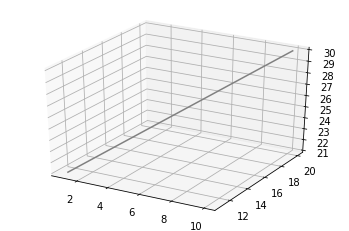

In [7]:
x1 = [1,2,3,4,5,6,7,8,9]
y1 = [11,12,13,14,15,16,17,18,19,20]
z1 = [21,22,23,24,25,26,27,28,29,30]

ax = plt.axes(projection='3d')
ax.plot3D(x1, y1, z1, 'gray')

In [56]:
x11 = np.array([1,2,3,4,5,6,7,8,9])
y11 = np.array([11,12,13,14,15,16,17,18,19])
z11 = np.arange(1,82).reshape(9,9)

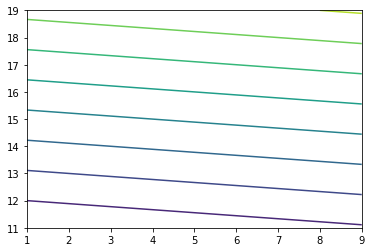

In [62]:
c = plt.contour(x11,y11, z11)

In [63]:
c

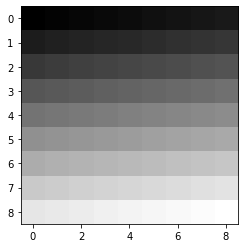

In [48]:
from skimage import measure
contours = measure.find_contours(z11)
plt.imshow(z11, cmap=plt.cm.gray)

In [55]:
contours[0].shape

(9, 2)

In [43]:
dat0= c.allsegs[1]

In [66]:
dat0[0].shape

(9, 2)

In [42]:
dat0[0].shape[0]

9